# 네이버 영화 리뷰 감성 분석

실행 환경: LMS

In [48]:
!pip install --upgrade gensim==3.8.3

In [49]:
import os
import pandas
import konlpy
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.initializers import Constant

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
3.8.3


## 데이터 불러오고 가공하기

먼저 txt에서 텍스트를 불러온다.

In [50]:
# 데이터를 읽기 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


노드 8-1에 의하면 결측치와 중복이 있다고 한다.
한번 확인해보자

In [51]:
# 데이터 결측치 확인
null_check = pd.isnull(train_data['document'])
null_data = train_data.loc[null_check, 'document']
null_data.head()

25857     NaN
55737     NaN
110014    NaN
126782    NaN
140721    NaN
Name: document, dtype: object

In [52]:
# 중복값 확인
dupl_check = train_data.duplicated(subset=['document'])
dupl_data = train_data.loc[dupl_check, 'document']
dupl_data.head()

1058      4
1097     쵝오
1248     최고
1483     최고
1707    재밌다
Name: document, dtype: object

중복이 있지만, 크게 문제가 되지 않을 것으로 보인다.

## 문자열 벡터화

문자열들을 벡터화한다.
이 과정에서 여러 중복함수들을 정리한다.

동시에 데이터셋을 구성한다.

In [53]:
def load_data(train_data, test_data):
    def tokenize_and_remove_stopword(data):
        res = []
#         r = []
        
        for sentence in data:
            temp = tokenizer.morphs(sentence)
#             temp = [word for word in temp if not word in stopwords]
            temp = list(filter(lambda x: x not in stopwords, temp))
            
#             tt = tokenizer.morphs(sentence)
#             tt = list(filter(lambda x: x not in stopwords, tt))
#             r.append(temp == tt)
                
            res.append(temp)
#         print(len(list(filter(lambda x: not x, r))))
        return res
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist] 
    
    
    tokenizer = Mecab()
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

    
    # 결측치와 중복을 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    # 토큰화와 불용어 제거
    X_train = tokenize_and_remove_stopword(train_data['document'])
    X_test = tokenize_and_remove_stopword(test_data['document'])

    # 단어사전 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # 상위 9996개 언어
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  #인덱스 정의
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 벡터화
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [54]:
# w 와 i를 뒤집은 딕셔너리 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [55]:
# 전체를 분석하기 위해서 모든 X를 결합
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = np.array([len(tokens) for tokens in total_data_text])

# 통계기반 신뢰구간 설정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('Coverage: {}'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
Coverage: 0.9342988343341575


In [56]:
# Padding seq 생성
# 뒤로갈수록 최종 값에 가장 영향을 많이주기 때문에 뒤에 패딩하는 것보다 앞에 패딩을 넣는 것이 좋음
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value=word_to_index["<PAD>"],
                                                     padding='pre',
                                                     maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre',
                                                    maxlen=maxlen)

In [57]:
# validation set 10000건 정도 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

partial_X_train.shape, partial_y_train.shape

((136182, 41), (136182,))

In [58]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 

## RNN 기반 모델 구성

In [112]:
# 시퀀셜 api로 모델 작성
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(128))
model1.add(keras.layers.Dense(32, activation='relu'))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dropout(0.5))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               168448    
_________________________________________________________________
dense_41 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_18 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)               

In [113]:
# 모델 컴파일
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

# 학습 수행
history = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

# 평가
results = model1.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history
print(history_dict.keys())

Epoch 1/5
266/266 [==============================] - 5s 15ms/step - loss: 0.4792 - accuracy: 0.7853 - val_loss: 0.3465 - val_accuracy: 0.8450
Epoch 2/5
266/266 [==============================] - 4s 13ms/step - loss: 0.3764 - accuracy: 0.8495 - val_loss: 0.3246 - val_accuracy: 0.8580
Epoch 3/5
266/266 [==============================] - 4s 13ms/step - loss: 0.3377 - accuracy: 0.8658 - val_loss: 0.3253 - val_accuracy: 0.8626
Epoch 4/5
266/266 [==============================] - 4s 13ms/step - loss: 0.3063 - accuracy: 0.8789 - val_loss: 0.3494 - val_accuracy: 0.8588
Epoch 5/5
266/266 [==============================] - 4s 14ms/step - loss: 0.2829 - accuracy: 0.8874 - val_loss: 0.3713 - val_accuracy: 0.8606
1537/1537 - 4s - loss: 0.3792 - accuracy: 0.8563
[0.3792388141155243, 0.85633784532547]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


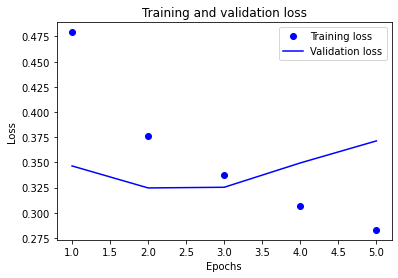

In [114]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

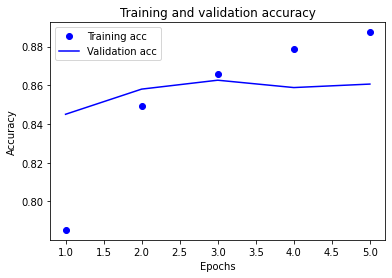

In [115]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 자동화 테스트 과정 구성 - 모델 학습 및 그래프 출력 까지 자동화

In [161]:
def test_pipeline(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=20, batch_size=512):
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=1)
    results = model.evaluate(X_test,  y_test, verbose=2)
    print(results)
    
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # 두 개의 축 생성
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # 첫 번째 플롯: Loss
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 두 번째 플롯: Accuracy
    ax2.plot(epochs, acc, 'bo', label='Training acc')
    ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()  # 축간 간격 조정
    plt.show()

## 임베딩 레이어 분석

In [118]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
weights.shape    # shape: (vocab_size, embedding_dim)

(10000, 200)

In [119]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    
f.close()

In [120]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.09076963,  0.0227139 , -0.00801047,  0.05027902, -0.01250664,
       -0.04315915,  0.057255  , -0.02902064, -0.05709456, -0.01051995,
        0.08074777, -0.06067792,  0.02793254,  0.01964548, -0.02355031,
        0.03974652, -0.01241663,  0.03037097, -0.05398101,  0.00961043,
       -0.06315618, -0.00996988, -0.01326016, -0.01911157,  0.03006818,
       -0.04206796,  0.07475884, -0.0501958 ,  0.03699642, -0.0831582 ,
        0.01059   , -0.0633682 ,  0.00705604,  0.02846874, -0.01749231,
        0.03718981,  0.00919766,  0.08990875, -0.06425989, -0.00961487,
       -0.09923198,  0.04200995, -0.06662161, -0.00413322,  0.02497877,
        0.01239535, -0.04489131, -0.10047162,  0.03716109,  0.08158157,
       -0.11920572, -0.01848743,  0.03864879,  0.06806229,  0.01308602,
       -0.08198884, -0.06668001,  0.06815343,  0.00890964,  0.00520173,
       -0.05908602,  0.01047349,  0.03926888,  0.07556399,  0.02479647,
        0.06252149,  0.02336962,  0.01651832, -0.05010941, -0.00

In [121]:
word_vectors.similar_by_word("재미")

[('경쾌', 0.6842935681343079),
 ('공감', 0.6749573945999146),
 ('창의', 0.666312575340271),
 ('띠', 0.6600446105003357),
 ('앨리스', 0.6590855121612549),
 ('매력', 0.654834508895874),
 ('경', 0.6533929109573364),
 ('긴장감', 0.652152419090271),
 ('앞서', 0.6511311531066895),
 ('어쨋든', 0.6493127346038818)]

자동화 테스트 과정 구성 - 임베딩 레이어 테스트 자동화

In [122]:
def analysis_embedding_layer(model, file_name):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape)    # shape: (vocab_size, embedding_dim)
    
    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
    word2vec_file_path = os.getenv('HOME')+f'/aiffel/{file_name}.txt'
    with open(word2vec_file_path, 'w') as f:
        f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

        # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
        vectors = model.get_weights()[0]
        for i in range(4,vocab_size):
            f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    vector = word_vectors['재미']
    
    print(vector)
    print(word_vectors.similar_by_word("재미"))
    return word_vectors.similar_by_word("재미")

## 1D CNN 모델

In [139]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 16)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)              

Epoch 1/4
286/286 [==============================] - 3s 7ms/step - loss: 0.6064 - accuracy: 0.6315 - val_loss: 0.3433 - val_accuracy: 0.8607
Epoch 2/4
286/286 [==============================] - 2s 7ms/step - loss: 0.4231 - accuracy: 0.8335 - val_loss: 0.2760 - val_accuracy: 0.8926
Epoch 3/4
286/286 [==============================] - 2s 7ms/step - loss: 0.3574 - accuracy: 0.8648 - val_loss: 0.2091 - val_accuracy: 0.9238
Epoch 4/4
286/286 [==============================] - 2s 7ms/step - loss: 0.2977 - accuracy: 0.8917 - val_loss: 0.1556 - val_accuracy: 0.9432
1537/1537 - 3s - loss: 0.3716 - accuracy: 0.8519
[0.37157130241394043, 0.8519030809402466]


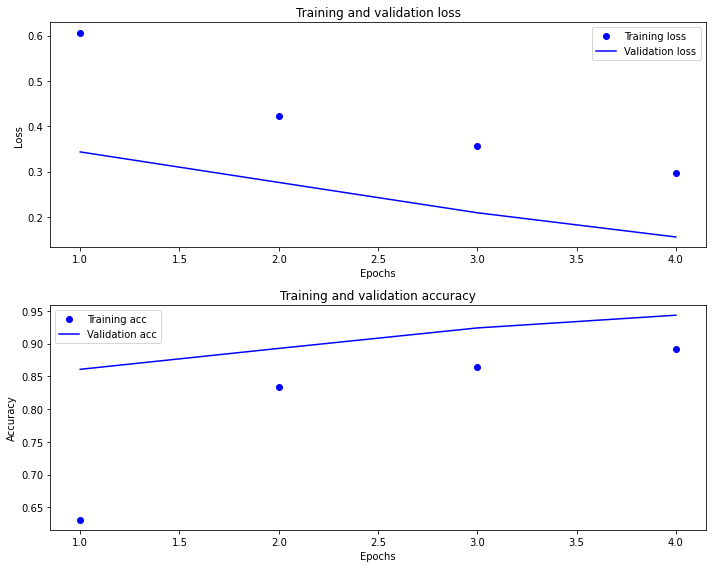

In [140]:
test_pipeline(model2, X_train, y_train, X_val, y_val, X_test, y_test, epochs=4, batch_size=512)

In [141]:
analysis_embedding_layer(model2, file_name='word2vec_cnn')

(10000, 200)
[ 1.41829774e-01 -3.98525083e-03  3.70806791e-02  5.58335669e-02
  4.09734026e-02  1.54839847e-02 -5.35355471e-02  3.01092509e-02
 -3.93158197e-03  5.20958826e-02 -2.71582585e-02  5.11253178e-02
 -8.45088437e-02  6.48738444e-02 -5.89775033e-02 -2.33647358e-02
  4.86357063e-02  2.42823325e-02  7.68822581e-02 -2.12788172e-02
  1.76720507e-02 -1.21219940e-02  6.50575431e-03  9.19199511e-02
  2.22760849e-02  4.23777997e-02 -4.06367658e-03  6.99232519e-02
 -3.01481094e-02 -1.99818555e-02 -1.58527121e-02 -1.22664645e-02
  7.30846226e-02 -4.46255924e-03  9.79957581e-02 -4.76105586e-02
 -8.94871876e-02  1.31001860e-01  2.99383458e-02 -2.08665758e-01
  4.00157366e-03 -3.25529091e-02 -5.79244122e-02 -8.25297274e-03
 -2.36243345e-02 -2.59553529e-02 -9.75596625e-03 -2.49521900e-02
  3.79784778e-02 -1.95371341e-02  1.38735622e-01 -1.15904570e-01
 -2.91680116e-02 -3.22890468e-02 -1.25501797e-01 -1.06518797e-03
  1.11437649e-01  1.01998463e-01  1.56520512e-02  3.81883495e-02
 -3.56375314

[('열라', 0.5831129550933838),
 ('겁내', 0.5576776266098022),
 ('브', 0.5325601696968079),
 ('비참', 0.5272516012191772),
 ('사마', 0.523006796836853),
 ('떴', 0.5202133059501648),
 ('두뇌', 0.5175384283065796),
 ('잴', 0.49752697348594666),
 ('완결', 0.48297756910324097),
 ('손예진', 0.47904127836227417)]

## GlobalMaxPooling1D 모델

In [249]:
# vocab_size = 10
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.Dropout(0.3))
# model3.add(tf.keras.layers.GlobalMaxPooling1D())
# model3.add(keras.layers.Dropout(0.3))
model3.add(keras.layers.GlobalAveragePooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))

model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_73 (Embedding)     (None, None, 200)         2000      
_________________________________________________________________
dropout_127 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
global_average_pooling1d_19  (None, 200)               0         
_________________________________________________________________
dropout_128 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 512)               102912    
_________________________________________________________________
dropout_129 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 128)             

Epoch 1/10
286/286 [==============================] - 3s 7ms/step - loss: 0.0494 - accuracy: 0.9791 - val_loss: 0.0061 - val_accuracy: 0.9964
Epoch 2/10
286/286 [==============================] - 2s 7ms/step - loss: 0.0505 - accuracy: 0.9791 - val_loss: 0.0056 - val_accuracy: 0.9965
Epoch 3/10
286/286 [==============================] - 2s 7ms/step - loss: 0.0475 - accuracy: 0.9801 - val_loss: 0.0057 - val_accuracy: 0.9966
Epoch 4/10
286/286 [==============================] - 2s 7ms/step - loss: 0.0480 - accuracy: 0.9801 - val_loss: 0.0057 - val_accuracy: 0.9965
Epoch 5/10
286/286 [==============================] - 2s 7ms/step - loss: 0.0493 - accuracy: 0.9793 - val_loss: 0.0054 - val_accuracy: 0.9967
Epoch 6/10
286/286 [==============================] - 2s 7ms/step - loss: 0.0504 - accuracy: 0.9786 - val_loss: 0.0059 - val_accuracy: 0.9963
Epoch 7/10
286/286 [==============================] - 2s 7ms/step - loss: 0.0483 - accuracy: 0.9797 - val_loss: 0.0057 - val_accuracy: 0.9966
Epoch 

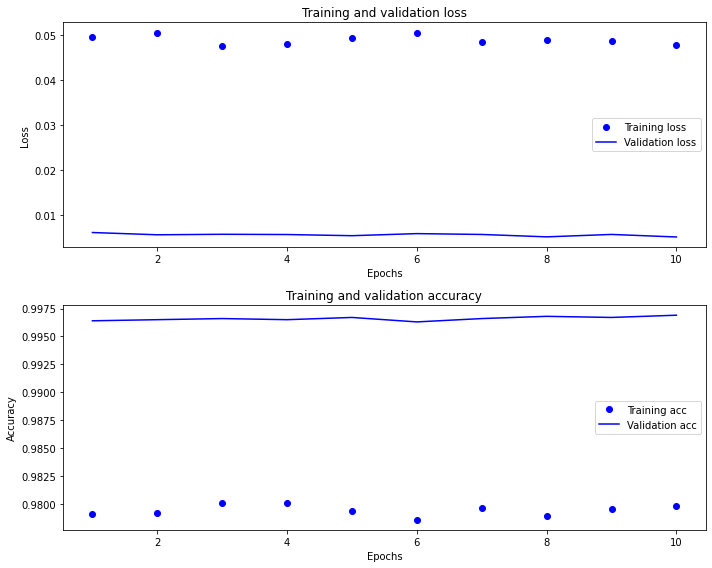

In [250]:
test_pipeline(model2, X_train, y_train, X_val, y_val, X_test, y_test, epochs=10, batch_size=512)

In [74]:
analysis_embedding_layer(model2, file_name='word2vec_gmp')

(10000, 16)
[ 0.0269236   0.05933017 -0.03113574  0.1688155  -0.0057016  -0.20828827
  0.07901016 -0.04985972  0.02870748  0.01552826 -0.15570454  0.06477226
 -0.04405908 -0.01827602 -0.2632488  -0.13517427]
[('뜰', 0.8016211986541748), ('패밀리', 0.7488318085670471), ('애환', 0.724683403968811), ('한몫', 0.6993271112442017), ('평타', 0.6987704038619995), ('입도', 0.6928943395614624), ('성실', 0.6885826587677002), ('애기', 0.6836316585540771), ('국가', 0.6787831783294678), ('그리워', 0.6753263473510742)]


[('뜰', 0.8016211986541748),
 ('패밀리', 0.7488318085670471),
 ('애환', 0.724683403968811),
 ('한몫', 0.6993271112442017),
 ('평타', 0.6987704038619995),
 ('입도', 0.6928943395614624),
 ('성실', 0.6885826587677002),
 ('애기', 0.6836316585540771),
 ('국가', 0.6787831783294678),
 ('그리워', 0.6753263473510742)]

In [75]:
rnn_res = analysis_embedding_layer(model1, file_name='word2vec_rnn')
cnn_res = analysis_embedding_layer(model2, file_name='word2vec_cnn')
gmp_res = analysis_embedding_layer(model3, file_name='word2vec_gmp')
print('===\n\n\n\n')

print('rnn')
print(rnn_res)

print('cnn')
print(cnn_res)

print('gmp')
print(gmp_res)

(10000, 16)
[ 0.20740953 -0.04264771  0.10526827  0.03808155  0.08443398 -0.09951105
  0.00072254 -0.16501781 -0.05575598  0.0355994   0.11434019 -0.10337137
 -0.09362173 -0.09174373 -0.04087929 -0.08242432]
[('이렇게', 0.9341796040534973), ('기대', 0.8805073499679565), ('굉장히', 0.8617286682128906), ('끌려서', 0.8517288565635681), ('흥미', 0.8507465720176697), ('캐', 0.8500837683677673), ('완전', 0.8429633378982544), ('공감', 0.8329155445098877), ('너무', 0.8246740698814392), ('영상', 0.8114273548126221)]
(10000, 16)
[ 0.0269236   0.05933017 -0.03113574  0.1688155  -0.0057016  -0.20828827
  0.07901016 -0.04985972  0.02870748  0.01552826 -0.15570454  0.06477226
 -0.04405908 -0.01827602 -0.2632488  -0.13517427]
[('뜰', 0.8016211986541748), ('패밀리', 0.7488318085670471), ('애환', 0.724683403968811), ('한몫', 0.6993271112442017), ('평타', 0.6987704038619995), ('입도', 0.6928943395614624), ('성실', 0.6885826587677002), ('애기', 0.6836316585540771), ('국가', 0.6787831783294678), ('그리워', 0.6753263473510742)]
(10000, 16)
[-0.0350

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [76]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin' 
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [77]:
word2vec.similar_by_word("재미")

/tmp/ipykernel_31/2795643307.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("재미")


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [78]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

/tmp/ipykernel_31/2656472433.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:


In [79]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   #trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [80]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
2128/2128 [==============================] - 14s 6ms/step - loss: 0.3808 - accuracy: 0.8265 - val_loss: 0.3161 - val_accuracy: 0.8622
Epoch 2/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.2839 - accuracy: 0.8797 - val_loss: 0.3031 - val_accuracy: 0.8722
Epoch 3/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.2409 - accuracy: 0.9006 - val_loss: 0.3049 - val_accuracy: 0.8737
Epoch 4/20
2128/2128 [==============================] - 12s 6ms/step - loss: 0.2005 - accuracy: 0.9191 - val_loss: 0.3182 - val_accuracy: 0.8735
Epoch 5/20
2128/2128 [==============================] - 12s 6ms/step - loss: 0.1598 - accuracy: 0.9376 - val_loss: 0.3607 - val_accuracy: 0.8660
Epoch 6/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.1218 - accuracy: 0.9544 - val_loss: 0.4077 - val_accuracy: 0.8639
Epoch 7/20
2128/2128 [==============================] - 13s 6ms/step - loss: 0.0919 - accuracy: 0.9664 - val_loss: 0.4793 - val_ac

In [81]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


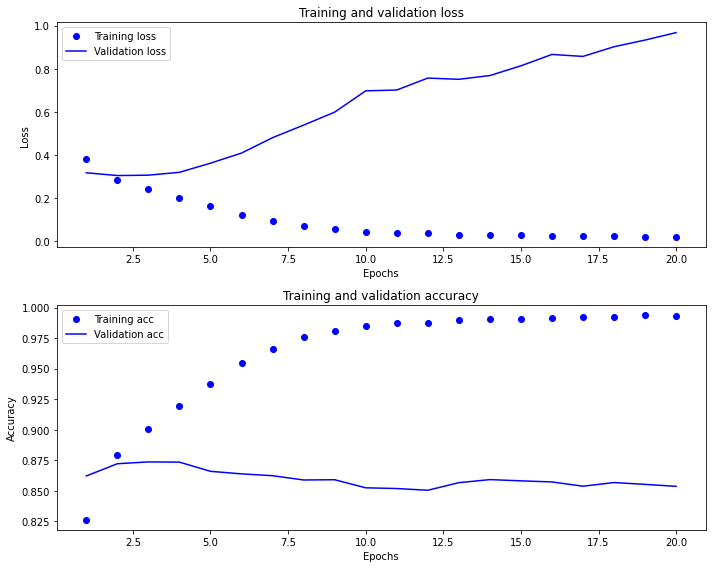

In [82]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 두 개의 축 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 첫 번째 플롯: Loss
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# 두 번째 플롯: Accuracy
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()  # 축간 간격 조정
plt.show()

In [83]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.9743 - accuracy: 0.8520


85.39% 달성

## 자체 임베딩과 비교

In [84]:
rnn = [('매우', 0.8843027353286743), ('넘', 0.8789970278739929), ('이해도', 0.8782033920288086), ('가치', 0.8582432866096497), ('제외', 0.8562479019165039), ('공감', 0.8499742746353149), ('이미숙', 0.8411532044410706), ('표정', 0.8410723209381104), ('매력', 0.8393557071685791), ('긴장감', 0.8345389366149902)]
cnn = [('약자', 0.8051141500473022), ('정말', 0.7905513048171997), ('구요', 0.7825247049331665), ('중심', 0.7659239172935486), ('녹', 0.7606545686721802), ('툭툭', 0.7492883205413818), ('커', 0.7468106746673584), ('흥겹', 0.7396458387374878), ('가능', 0.7390083074569702), ('삐', 0.7200238704681396)]
gmp = [('단체', 0.7845001220703125), ('사후', 0.7741118669509888), ('갤', 0.7567523717880249), ('권력', 0.7354912161827087), ('신체', 0.7154641151428223), ('아마', 0.7075228691101074), ('일제', 0.6915094256401062), ('추격전', 0.6897620558738708), ('단면', 0.6868882179260254), ('볼걸', 0.6830145716667175)]
kow2v = [('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

sorted_rnn = sorted(rnn, key=lambda x: x[1], reverse=True)
sorted_cnn = sorted(cnn, key=lambda x: x[1], reverse=True)
sorted_gmp = sorted(gmp, key=lambda x: x[1], reverse=True)
sorted_kow2v = sorted(kow2v, key=lambda x: x[1], reverse=True)

for r, c, g, k in zip(sorted_rnn, sorted_cnn, sorted_gmp, sorted_kow2v):
    print(f'{r}|{c}|{g}|{k}')


('매우', 0.8843027353286743)|('약자', 0.8051141500473022)|('단체', 0.7845001220703125)|('취미', 0.5857348442077637)
('넘', 0.8789970278739929)|('정말', 0.7905513048171997)|('사후', 0.7741118669509888)|('유머', 0.5140613913536072)
('이해도', 0.8782033920288086)|('구요', 0.7825247049331665)|('갤', 0.7567523717880249)|('매력', 0.5105490684509277)
('가치', 0.8582432866096497)|('중심', 0.7659239172935486)|('권력', 0.7354912161827087)|('흥미', 0.4988338351249695)
('제외', 0.8562479019165039)|('녹', 0.7606545686721802)|('신체', 0.7154641151428223)|('공짜', 0.4960595667362213)
('공감', 0.8499742746353149)|('툭툭', 0.7492883205413818)|('아마', 0.7075228691101074)|('일자리', 0.49294644594192505)
('이미숙', 0.8411532044410706)|('커', 0.7468106746673584)|('일제', 0.6915094256401062)|('즐거움', 0.48700767755508423)
('표정', 0.8410723209381104)|('흥겹', 0.7396458387374878)|('추격전', 0.6897620558738708)|('비애', 0.4836210310459137)
('매력', 0.8393557071685791)|('가능', 0.7390083074569702)|('단면', 0.6868882179260254)|('관객', 0.48286449909210205)
('긴장감', 0.83453893661499

위는 주제어는 각각 '재미'를 주제로 유사 단어를 추출한 결과이다.
기본적으로 파인튜닝한 쪽이 사람이 봤을 때 유사한 단어가 많다.

대표적으로 '유머', '매력', '취미', 그리고 '흥미'는 재미와 관련된 단어라는 것을 직관적으로 알 수 있다.
하지만 '메우'와 '넘'은 같이 자주 쓰이지만, '이해도' '가치', '약자' (넌.. 왜..), '갤' (DC 인사이드?) 등은 왜 있는지 연관성을 알 수 없다.

또한 이 페이지에서 나타나지 않지만, 위의 3개의 모델에는 85%를 넘기 위한 노력이 많이 들어갔으나, 한국어 Word2Vec을 사용한 경우 적은 노력으로 85% 이상의 정확도를 달성할 수 있었다.

이를 통해, 워드 임베딩이 모델 성능과 평가 지표에 주는 영향력을 볼 수 있었다.